In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

import argparse

from net.network import SelfAttention, vgg_reverse, vgg, SAVANet
from net.models import Transform, SAVA_test
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--transformer_model', type=str, default='../../models/sava_training_hard/transformer_iter_96000.pth',
                    help='Directory path to a batch of transformer model')
parser.add_argument('--decoder_model', type=str, default='../../models/sava_training_hard/decoder_iter_96000.pth',
                    help='Directory path to a batch of decoder model')

parser.add_argument('--vgg_model', type=str, default='../../models/vgg/vgg_normalised.pth')

parser.add_argument('--attn_model', type=str, default='../../models/attention_training/attention_kernel_iter_80000.pth')

parser.add_argument('--content_dir', type=str, default='../../testing_data/content/',
                    help='Directory path to a batch of content images')
parser.add_argument('--style_dir', type=str, default='../../testing_data/style/',
                    help='Directory path to a batch of style images')

args = parser.parse_args('')

In [10]:
def test_transform(size = 512):
    transform = transforms.Compose([
        transforms.Resize(size=(size, size)),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ])
    return transform

def test_transform_inv():
    transform = transforms.Compose([
        transforms.Normalize((0, 0, 0), (2, 2, 2)),
        transforms.Normalize((-_R_MEAN/255.0, -_G_MEAN/255.0, -_B_MEAN/255.0), (1, 1, 1))
    ])
    return transform

def state_to_device(parameter, device):
    state_dict = parameter.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    parameter.cuda()
    

def imshow_pair(imgs, titles):
    f, axarr = plt.subplots(1,2) 
    axarr[0].imshow(np.transpose(imgs[0].numpy(), (1, 2, 0)))
    axarr[0].set_title(titles[0])
    axarr[1].imshow(np.transpose(imgs[1].numpy(), (1, 2, 0)))
    axarr[1].set_title(titles[1])

def imshow_recon(img, save_dir=None):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Transfer Output")
    if save_dir != None:
        print("Saving to " + str(save_dir))
        torchvision.utils.save_image(img, save_dir)
    
def show_output(output, save_dir=None):
    content_result = content_tf_inv(output.squeeze())
    imshow_recon(torchvision.utils.make_grid(content_result.cpu()), save_dir)

def attn_transfer(attn_map):
    channel_num = attn_map.size()[1]
    mean_sal = torch.mean(attn_map, 1, False)
    mean_sal_np = mean_sal.cpu().detach().numpy()
    mean_sal_np = mean_sal_np - np.min(mean_sal_np)
    mean_sal_np = mean_sal_np * 1.0 / np.max(mean_sal_np)
    return mean_sal_np[0]

def show_attn_map(attn_maps, titles, save_dir=None):
    results = [attn_transfer(attn_maps[0]), attn_transfer(attn_maps[1]),attn_transfer(attn_maps[2]), attn_transfer(attn_maps[3])]
    f, axarr = plt.subplots(1,4) 
    
    axarr[0].imshow(results[0], cmap=cm.get_cmap('rainbow', 1000))
    axarr[0].set_title(titles[0])
    axarr[0].axis('off')
    axarr[1].imshow(results[1], cmap=cm.get_cmap('rainbow', 1000))
    axarr[1].axis('off')
    axarr[2].imshow(results[2], cmap=cm.get_cmap('rainbow', 1000))
    axarr[2].set_title(titles[1])
    axarr[2].axis('off')
    axarr[3].imshow(results[3], cmap=cm.get_cmap('rainbow', 1000))
    axarr[3].axis('off')
    
    if save_dir != None:
        f.savefig(save_dir)
        
def show_diagram(attn_maps):
    f, axarr = plt.subplots(2,1) 
    
    x = np.arange(1,attn_maps[0].shape[0]+1)
    axarr[0].plot(x,attn_maps[0])
    axarr[0].set_title("Relative Frequency Histogram")
    
    x = np.arange(1,attn_maps[1].shape[0]+1)
    axarr[1].plot(x,attn_maps[1])


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

In [5]:
content_name = 'content-01.jpg'
style_name = 'style-01.jpg'

content_tf = test_transform(int(800))
style_tf = test_transform(int(512))
content_tf_inv = test_transform_inv()

content_img = content_tf(Image.open(args.content_dir + content_name).convert('RGB'))
style_img = style_tf(Image.open(args.style_dir + style_name).convert('RGB'))

In [6]:
encoder = vgg
encoder.load_state_dict(torch.load(args.vgg_model))
state_to_device(encoder, device)

self_attn = SelfAttention()
self_attn.load_state_dict(torch.load(args.attn_model))
state_to_device(self_attn, device)

transformer = Transform(in_channel = 512, self_attn=self_attn)
transformer.load_state_dict(torch.load(args.transformer_model))
state_to_device(transformer, device)

decoder = vgg_reverse
decoder.load_state_dict(torch.load(args.decoder_model))
state_to_device(decoder, device)

model = SAVA_test(transformer=transformer, encoder=encoder, decoder=decoder)
model = model.cuda()


In [7]:
content = content_img.unsqueeze(0)
print(content.shape)
print(content_img.shape)
content = content.to(device)
style = torch.stack([style_img], dim = 0)
style = style.to(device)
output, swapped_features, [content_attn4_1, style_attn4_1, content_attn5_1, style_attn5_1] = model.transfer(content, style)

torch.Size([1, 3, 800, 800])
torch.Size([3, 800, 800])


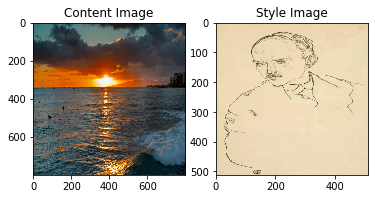

In [8]:
imshow_pair([torchvision.utils.make_grid(content_tf_inv(content_img)),torchvision.utils.make_grid(content_tf_inv(style_img))], ["Content Image", "Style Image"])

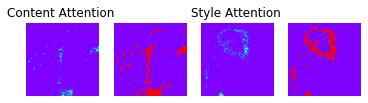

In [11]:
content_mask = transformer.savanet4_1.attn_mask(content_attn4_1)
style_mask = transformer.savanet4_1.attn_mask(style_attn4_1)
show_attn_map([content_attn4_1, content_mask, style_attn4_1, style_mask], ["Content Attention ", "Style Attention "])

In [ ]:
style_attn4_1.sum()

In [ ]:
attn_frequency = [content_attn4_1[0].reshape((1, -1)).cpu().detach().numpy()[0], style_attn4_1[0].reshape((1, -1)).cpu().detach().numpy()[0]]
show_diagram(attn_frequency)

In [ ]:
show_output(output)